In [ ]:
pip install darts

In [9]:
import warnings
import darts
import sys
from math import sqrt
import pandas as pd
from darts import TimeSeries
import matplotlib.pyplot as plt

# Airline Passengers dataset import

In [3]:
df = pd.read_csv("/kaggle/input/dataset5/airline_passengers.csv", infer_datetime_format=True,parse_dates=["Month"],index_col=["Month"])

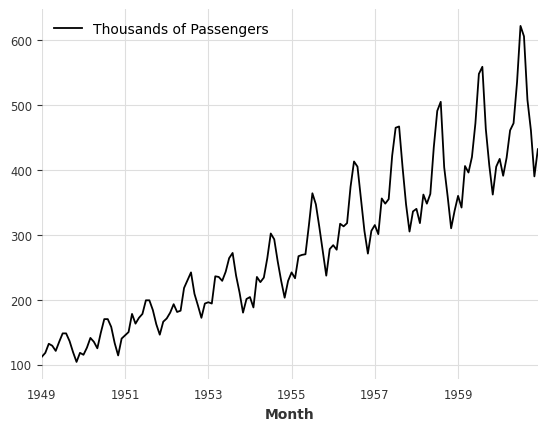

In [6]:
df.plot()
plt.show()

# Focus on the residuals
We want to train our model only on the residuals, so we have to remove all the non-stationary components present in the dataset.

In this case we already know that there is a clear increasing trend and also seasonality with a period of 12. We also already know how to obtain the residual without trend and seasonality.

First we remove the trend:

In [7]:
detrended_data_set = df.diff()

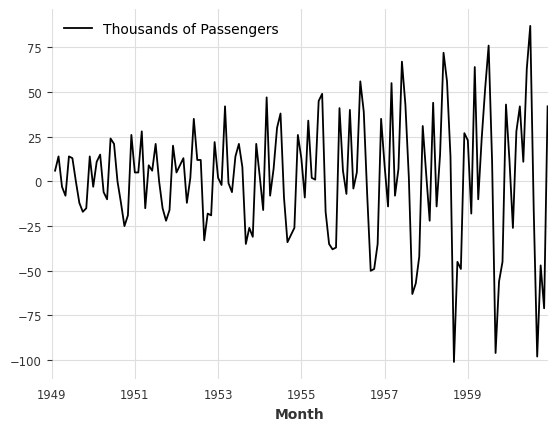

In [8]:
detrended_data_set.plot()
plt.show()

And then we remove the seasonality:

In [9]:
residuals = detrended_data_set.diff(12)

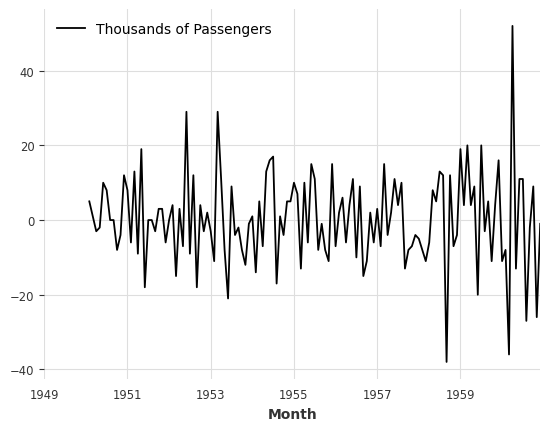

In [10]:
residuals.plot()
plt.show()

Then we transform the dataframe to a series

In [11]:
series = TimeSeries.from_dataframe(df)
residuals_series = TimeSeries.from_dataframe(residuals)

# Train-Test Split
Since we are starting to create the models to forecast, we need to split our original dataset into train and test data, in this way we are able to evaluate the performance of each technique. Indeed, the objective is to estimate the performance of the machine learning model on new data: data not used to train the model.

The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model and is referred to as the training dataset. The second subset is not used to train the model; instead, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values. This second dataset is referred to as the test dataset.

* Train Dataset: Used to fit the machine learning model.
* Test Dataset: Used to evaluate the fit machine learning model.

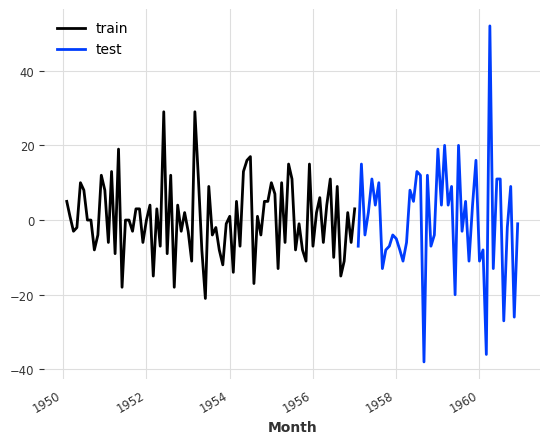

In [12]:
train,test = residuals_series.split_before(pd.Timestamp("19570102"))
train = train.strip()
train.plot(label="train")
test.plot(label="test")

# **Naive Forecast**
A naive forecast, also known as a simple or basic forecast, is a straightforward forecasting technique that assumes future values will be the same as the most recent or historical value. It does not take into account any underlying patterns, trends, or factors that may influence the data. The naive forecast essentially assumes that the future will be a continuation of the past, without considering any external factors or changes in the data.

In [12]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_pred = naive_model.predict(len(test))

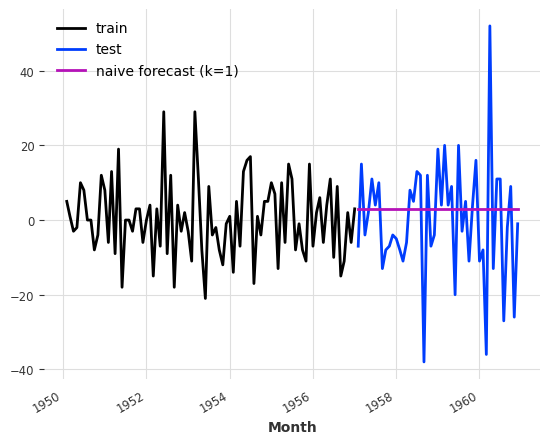

In [13]:
train.plot(label="train")
test.plot(label="test")
naive_pred.plot(label="naive forecast (k=1)")

# **Naive Simple Mean**
The naive simple mean is a basic statistical method used to calculate the average of a set of numerical values. It involves summing all the values in the set and then dividing the sum by the total number of values. 
This approach assumes that all values are equally important and does not consider any other factors or variations within the data.

In [14]:
from darts.models import NaiveMean

naivemean_model = NaiveMean()
naivemean_model.fit(train)
naivemean_pred = naivemean_model.predict(len(test))

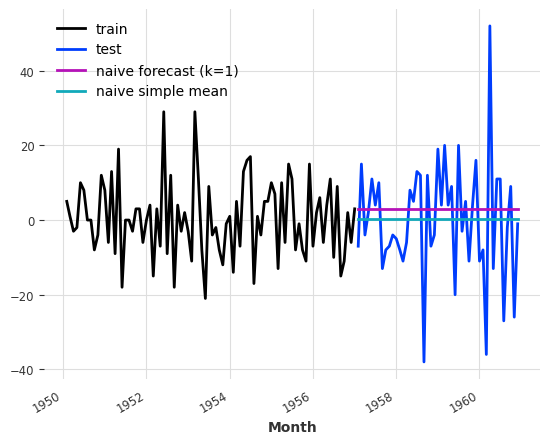

In [15]:
train.plot(label="train")
test.plot(label="test")
naive_pred.plot(label="naive forecast (k=1)")
naivemean_pred.plot(label="naive simple mean")

In [16]:
naive_model.backtest(series)

9.04942269773711

In [17]:
naivemean_model.backtest(series)

28.367408804261917

# **Simple Exponential Smoothing**
Simple exponential smoothing is a forecasting technique that assigns exponentially decreasing weights to past observations, placing more emphasis on recent data points while diminishing the impact of older ones. It assumes that the future value of a time series is a weighted average of past observations, with the weights exponentially decreasing as the observations become older. This smoothing method is useful for forecasting data without trend or seasonality, providing a quick and straightforward approach to make predictions based on historical values.

In [13]:
from darts.models import ExponentialSmoothing
from darts.utils.utils import ModelMode
from darts.utils.utils import SeasonalityMode

simpleExponential_model = ExponentialSmoothing(trend=ModelMode.NONE, seasonal=SeasonalityMode.NONE)
simpleExponential_model.fit(train)
simpleExponential_pred = simpleExponential_model.predict(len(test))

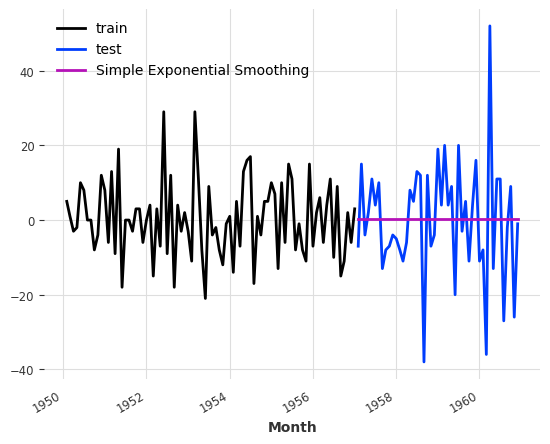

In [14]:
train.plot(label="train")
test.plot(label="test")
simpleExponential_pred.plot(label="Simple Exponential Smoothing")

# **Holt & Holt-Winters**
Holt's exponential smoothing, also known as double exponential smoothing, is a forecasting technique that extends simple exponential smoothing to include a trend component. It takes into account both the level and trend of the time series data when making predictions.

Holt-Winters' exponential smoothing, also called triple exponential smoothing, is an advanced forecasting technique that incorporates not only the level and trend but also the seasonality of the time series data. It extends Holt's exponential smoothing by adding a seasonal component to the model.

In [19]:
holt_model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, 
                                  seasonal=SeasonalityMode.NONE)
holt_model.fit(train)
holt_pred = holt_model.predict(len(test))

holtWinters_model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, 
                                         seasonal=SeasonalityMode.ADDITIVE)
holtWinters_model.fit(train)
holtWinters_pred = holtWinters_model.predict(len(test))

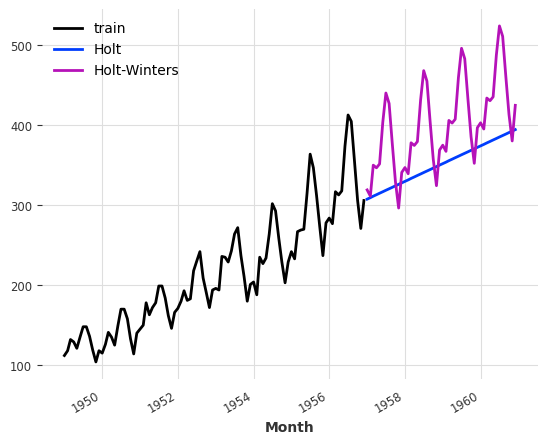

In [20]:
train.plot(label="train")
holt_pred.plot(label="Holt")
holtWinters_pred.plot(label="Holt-Winters")

# **Models Evaluation**

In [21]:
from darts.metrics import mape
from darts.metrics import mae
from darts.metrics import mse
from darts.metrics import rmse

mapeES = mape(test,simpleExponential_pred)
maeES = mae(test,simpleExponential_pred)
mseES = mse(test, simpleExponential_pred)
rmseES = rmse(test, simpleExponential_pred)

print(mapeES, maeES, mseES, rmseES)

99.91718647324817 415.2411346638032 178376.4656479826 422.34638112334125


In [22]:
mapeH = mape(test,holt_pred)
maeH = mae(test,holt_pred)
mseH = mse(test, holt_pred)
rmseH = rmse(test, holt_pred)

print(mapeH, maeH, mseH, rmseH)

14.435796692157085 67.22125618107009 8349.89498022825 91.37775976805433


In [24]:
mapeHW = mape(test,holtWinters_pred)
maeHW = mae(test,holtWinters_pred)
mseHW = mse(test, holtWinters_pred)
rmseHW = rmse(test, holtWinters_pred)

print(mapeHW, maeHW, mseHW, rmseHW)

5.0332534674229885 22.83729441824266 1018.784635022018 31.91840589725649


# Backtest
Compute error values that the model would have produced when used on potentially multiple series

In [28]:
scoreExponentialSmoothing = simpleExponential_model.backtest(series)
scoreHolt = holt_model.backtest(series)
scoreHoltWinters = holtWinters_model.backtest(series)
print(scoreExponentialSmoothing, scoreHolt, scoreHoltWinters)

9.102210342976 9.500892787895488 3.709005816470997


# **Seasonal Autoregressive Integrated Moving-Average (SARIMA)**

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

In [29]:
from darts.models import ARIMA
from darts.models import AutoARIMA

In [30]:
series = TimeSeries.from_dataframe(df)

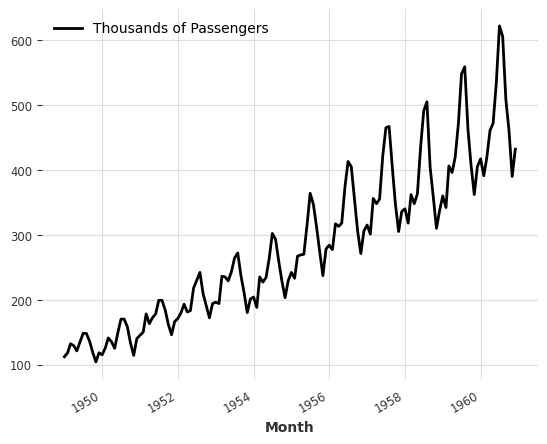

In [31]:
series.plot()
plt.show()

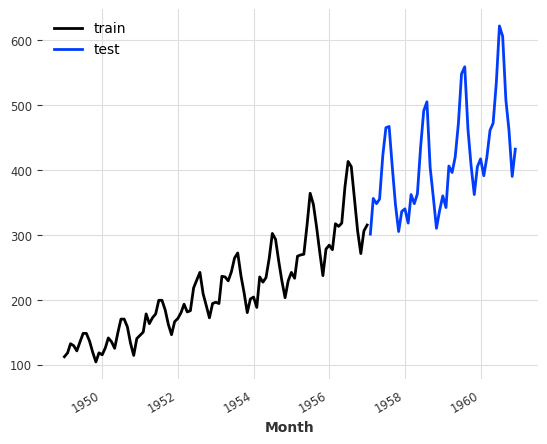

In [32]:
train,test = series.split_before(pd.Timestamp("19570102"))
train = train.strip()
train.plot(label="train")
test.plot(label="test")

# Auto ARIMA
The Auto ARIMA model automatically determines the optimal values for the parameters of the ARIMA model, including the order of auto-regressive (AR), integrated (I), and moving average (MA) components. It selects the best model based on statistical criteria and iterative algorithms.

In [33]:
model_aarima = AutoARIMA(start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=10,
                        max_order=5, m=12)
model_aarima.fit(train)
prediction_aarima = model_aarima.predict(len(test))

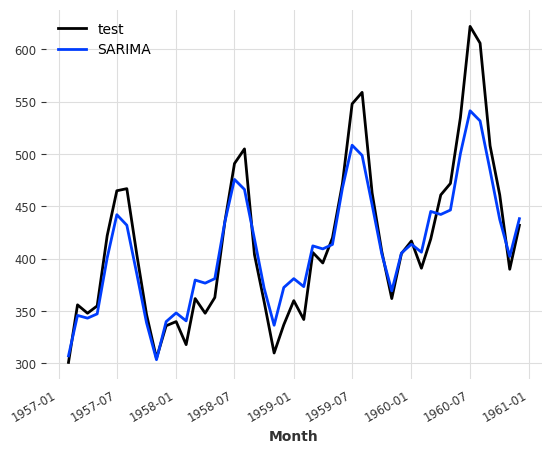

In [34]:
test.plot(label="test")
prediction_aarima.plot(label="Auto ARIMA")

In [35]:
model_arima = ARIMA(2, 1, 0, seasonal_order=(1,1,0,12))
model_arima.fit(train)
model_arima_pred = model_arima.predict(len(test))

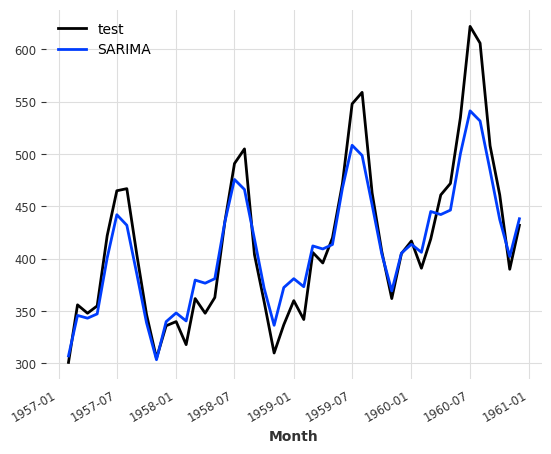

In [36]:
test.plot(label="test")
model_arima_pred.plot(label="ARIMA")

In [37]:
scoreAutoARIMA = mape(test,prediction_aarima)
scoreARIMA = mape(test,model_arima_pred)
print(scoreAuto, scoreSARIMA)

4.489664502895612 4.488811736556145


In [38]:
scoreAutoARIMA = mse(test,prediction_aarima)
scoreARIMA = mse(test,model_arima_pred)
print(scoreAuto, scoreSARIMA)

690.7064429559698 691.444713306636


In [39]:
scoreAutoARIMA = mae(test,prediction_aarima)
scoreARIMA = mae(test,model_arima_pred)
print(scoreAuto, scoreSARIMA)

19.706575108511466 19.709164916613968


In [40]:
scoreAutoARIMA = rmse(test,prediction_aarima)
scoreARIMA = rmse(test,model_arima_pred)
print(scoreAuto, scoreSARIMA)

26.28129454490341 26.295336341386395
